# Data Science Individual Planning Stage
**By: Ricky Shi**

---

## Data Description

- For this project, I will be working with two datasets: `players.csv` and `sessions.csv` which come from a Minecraft research server managed by UBC’s Computer Science department. The data includes player demographics and in-game activity
- To answer my project question, I will be primarily using the `players.csv` dataset to perform various analyses

**Dataset Overview**
| Dataset | Rows (Observations) | Columns (Variables) | Description |
|----------|------|----------|--------------|
| `players.csv` | 196 | 7 | Contains hashed emails which will act as unique IDs for each player and demographics such as age, gender, total playtime in hours, and game newsletter subscription status |
| `sessions.csv` | 1535 | 5 | Contains session-level data, including hashed emails, start and end of gaming sessions, and the timestamp representations of the start and stop times|

**Potential Issues:**
- Missing age data from some players which could reduce the size of usable data for analysis
- Outliers in play duration (such as idle sessions) could cause inaccuracies in actual playtime 
- Imbalance in newsletter subscription (few “false” cases) could decrease the accuracy of predictions
- Non-uniform scaling across predictors, which will require standardization 

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Data Summary

Below is a brief summary on the counts, maximum, minimum, and mean of each variable in both datasets

In [3]:
players <- read_csv("data/players.csv")

sessions <- read_csv("data/sessions.csv")


players_summary <- players |>
  summarise(
    age_mean = mean(Age, na.rm = TRUE),
    age_min  = min(Age, na.rm = TRUE),
    age_max  = max(Age, na.rm = TRUE),
    hours_mean = mean(played_hours, na.rm = TRUE),
    hours_min  = min(played_hours, na.rm = TRUE),
    hours_max  = max(played_hours, na.rm = TRUE)
  )

sessions_summary <- sessions |>
  count(hashedEmail, name = "session_count") |>
  summarise(
    total_players = n(),
    total_sessions = sum(session_count),
    avg_sessions_per_player = round(mean(session_count), 1),
    min_sessions = min(session_count),
    max_sessions = max(session_count)
  )
players_summary
sessions_summary

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age_mean,age_min,age_max,hours_mean,hours_min,hours_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21.13918,9,58,5.845918,0,223.1


total_players,total_sessions,avg_sessions_per_player,min_sessions,max_sessions
<int>,<int>,<dbl>,<int>,<int>
125,1535,12.3,1,310


# Establishing the Question

**Broad Question**
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific Question**
Can a player's age and total playtime be used to predict whether they will subscribe to the game's newsletter?

To answer my specific question, I will be using the `players.csv` dataset and apply a K-nearest-neighbours classification model as it contains both predictor variables and the response variable `subscribe`. While a second dataset (`sessions.csv`) is available, it primarily provides per-session timing data rather than overall player behavior summaries.

# Exploratory Data Analysis and Visualization

- For this section, I will use the `players` dataset to summarize the mean of the predictor variables, and visualize their relationships with newsletter subscription in a scatterplot
- Not much wrangling is needed as the dataset is already tidy for my analysis

In [4]:
# Mean summary of predictor variables
mean_summary <- players |>
  summarise(
    mean_age = round(mean(Age, na.rm = TRUE), 2),
    mean_playtime = round(mean(played_hours, na.rm = TRUE), 2)
  )

mean_summary

mean_age,mean_playtime
<dbl>,<dbl>
21.14,5.85


**Data Visualization**
- The scatterplot below shows that players who subscribed to the newsletter generally have higher playtimes
- The y axis is scaled using a log base 10 scale to compress extreme values and improve the visibility of clustered points
  
**Observations**
- From the scatterplot, there appears to be a large amount of players with a low total playtime, particularly below 10 hours
- Most newsletter subscribers (blue points) seem to be spread across different playtime levels, while though some high-playtime players are also subscribers
- There appears to be a weak negative relationship between age and playtime, and both younger and older players appear in both subscription groups

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


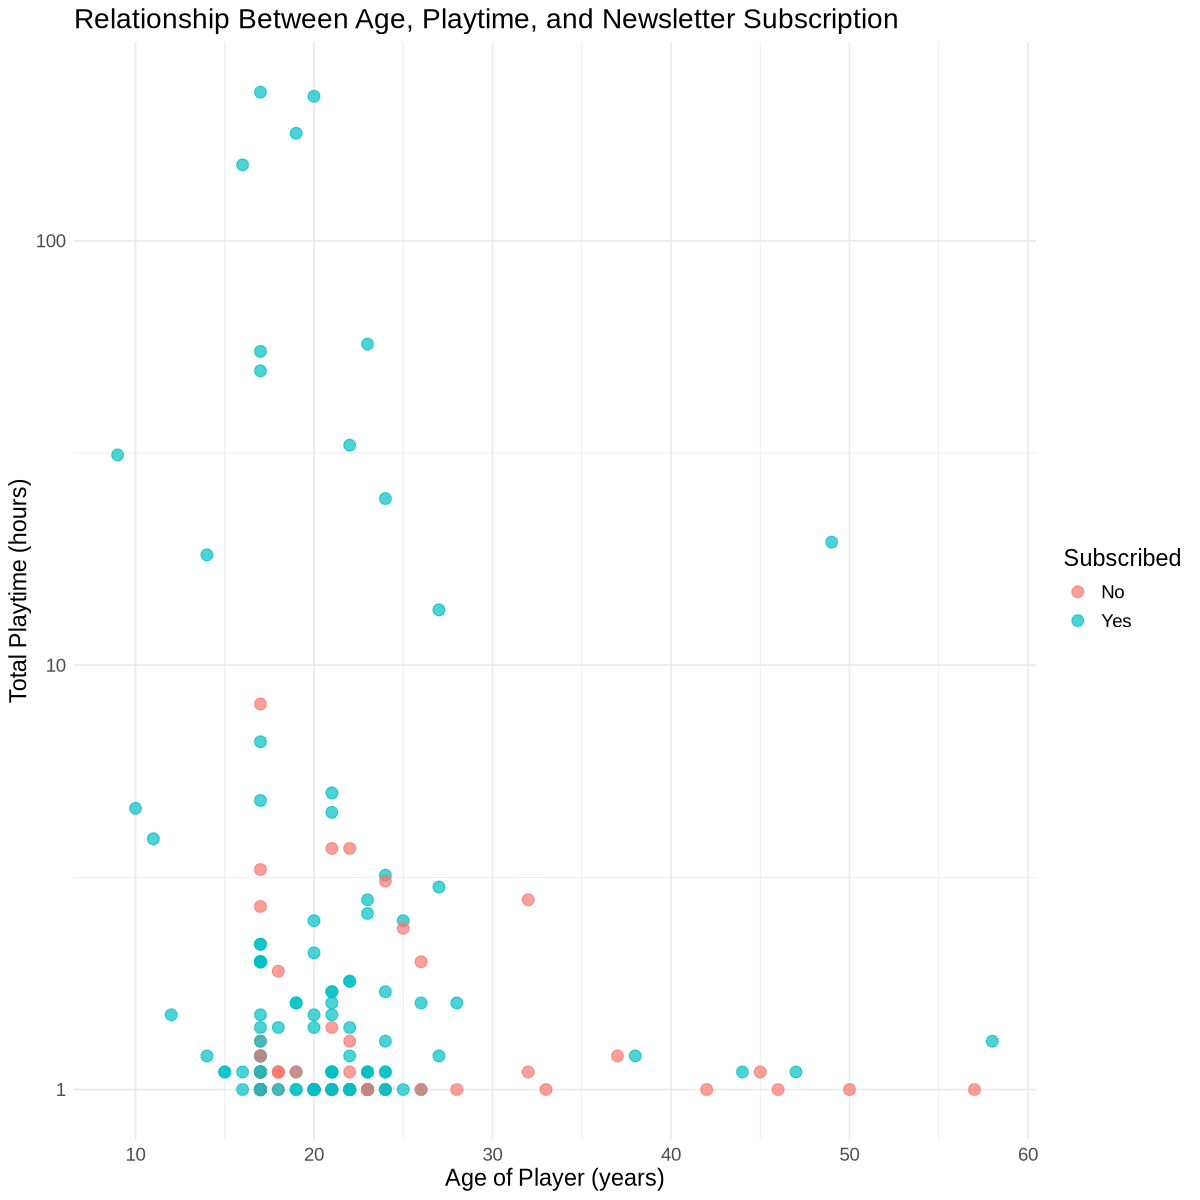

In [6]:
# Scatterplot visualizing the relationship between the predictors and newsletter subscription 

options(repr.plot.width = 10, repr.plot.height = 10)

players <- players |>
  mutate(subscribe = as_factor(subscribe), subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))

players_plot <- ggplot(players, aes(x = Age, y = played_hours + 1, color = subscribe)) +
  geom_point(alpha = 0.7, size = 3) +
  scale_y_log10() +
  labs(x = "Age of Player (years)", y = "Total Playtime (hours)", color = "Subscribed") +
  ggtitle("Relationship Between Age, Playtime, and Newsletter Subscription") +
  theme_minimal() +
  theme(text = element_text(size = 14))

players_plot 